## Implementing SRRESNET  paper
Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network
https://arxiv.org/pdf/1609.04802.pdf


![srgan_results](./Figure/srgan.png)
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;SRRESNET 4x upscaling&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;SRGAN 4x upscaling&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;ORIGINAL    

In [2]:
from IPython import get_ipython
if get_ipython() is not None:
    import matplotlib
    if matplotlib.get_backend() != 'agg':
      get_ipython().run_line_magic('matplotlib', 'inline')

In [3]:
import os 
import pandas as pd
import matplotlib.pyplot as plt


from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from glob import glob
import PIL
from PIL import Image
import numpy as np


import fastestimator as fe
from fastestimator.dataset import srgan
from fastestimator.op import TensorOp
from fastestimator.op.tensorop import Loss, ModelOp, Rescale
from fastestimator.trace import LRController, ModelSaver
from fastestimator.schedule.lr_scheduler import LRSchedule
from fastestimator.op.numpyop import ImageReader, ResizeImageAndBbox, TypeConverter
from fastestimator.layers.sub_pixel_conv_2d import SubPixelConv2D


from tensorflow.keras.layers  import Input, Conv2D, BatchNormalization, Flatten, Dense, Add, LeakyReLU, PReLU
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model 
import tensorflow as tf

In [5]:
epochs = 100 # 100
batch_size = 4 # 4 
steps_per_epoch = 9000 # 9000
model_write_dir = "the dir path to write model"
dataset_path = "the path to ImageNet dir"

### Download the ImageNet dataset. Currently the script doesn't download the ImageNet data.
ImageNet folder is expected to be in the standard format, having 'train' and 'val' subdirectories. The following script when run

- randomly selects around 350,000 images from the ImageNet dataset
- selected images are cropped to 96x96 subimages , these form the high resolution images
- High resolution images are then downsized by a factor 4 using cubic interpolation. These form the low resolution images. Low resolution image have size 24x24x3
- training csv is created along with validation csv

In [6]:
train_csv, val_csv, path = srgan.load_data(path_imgnet=dataset_path)

In [7]:
df = pd.read_csv(train_csv)
df.head()

,lowres,highres
0,/home/ubuntu/fastestimator_data/ImageNet2012/t...,/home/ubuntu/fastestimator_data/ImageNet2012/t...
1,/home/ubuntu/fastestimator_data/ImageNet2012/t...,/home/ubuntu/fastestimator_data/ImageNet2012/t...
2,/home/ubuntu/fastestimator_data/ImageNet2012/t...,/home/ubuntu/fastestimator_data/ImageNet2012/t...
3,/home/ubuntu/fastestimator_data/ImageNet2012/t...,/home/ubuntu/fastestimator_data/ImageNet2012/t...
4,/home/ubuntu/fastestimator_data/ImageNet2012/t...,/home/ubuntu/fastestimator_data/ImageNet2012/t...


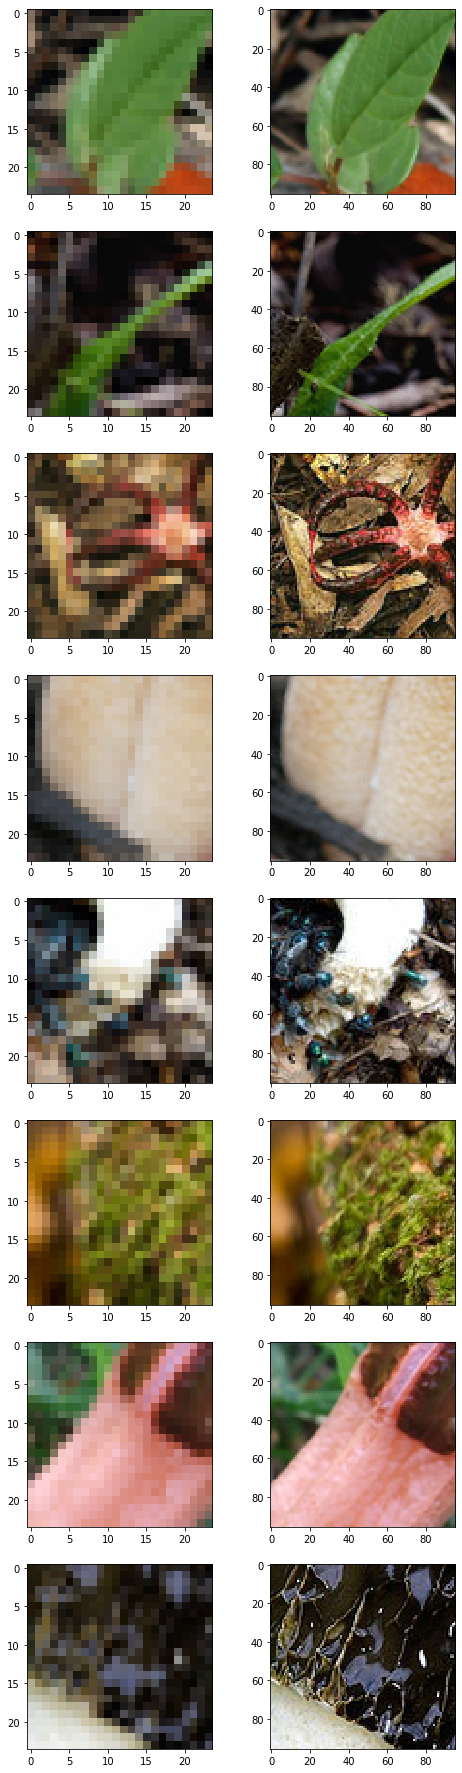

In [8]:
fig, axes = plt.subplots(nrows=8, ncols=2)
fig.set_figheight(32)
fig.set_figwidth(8)
for row,(imgpath_low, imgpath_high) in enumerate(zip(df['lowres'].values[355302:355310], 
                                                     df['highres'].values[355302:355310])):
    img_low = Image.open(imgpath_low)
    img_low = np.array(img_low)
    img_high = Image.open(imgpath_high)
    img_high = np.array(img_high)
    
    axes[row, 0].imshow(img_low)
    axes[row, 1].imshow(img_high)
plt.show()

### Preprocessing
- Preprocessing of low resolution images is carried out by LowresRescale.  Image values end up between (0,1)
- Preprocessing of high resolution images is carried out by Rescale. Image values end up between (-1,1)

In [9]:
class LowresRescale(TensorOp):
    """Rescaling data according to

    Args:
        inputs: Name of the key in the dataset that is to be filtered.
        outputs: Name of the key to be created/used in the dataset to store the results.
        mode: mode that the filter acts on.
    """
    def __init__(self, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)

    def forward(self, data, state):
        data = tf.cast(data, tf.float32)
        data /= 255
        return data

### Create TF Records from high res and low res images

In [10]:
writer = fe.RecordWriter(
        save_dir=os.path.join(path, "sr_tfrecords"),
        train_data= train_csv,
        validation_data=val_csv,
        ops=[
            ImageReader(inputs="lowres", outputs="lowres"),
            ImageReader(inputs="highres", outputs="highres")
            
        ],
        compression="GZIP",
        write_feature=[
            'lowres', 'highres'
        ])

### Create data pipeline
Please note that the batch_size is 4 . The srgan/srresnet paper stipulates that the batch size should be 16. <br> The training has been carried out in p3.8xlarge ec2 instance having 4 V100.<br>
Fastestimator leverages tf.distributed strategy, effecting the batch_size to be 16 (4 gpus * 4 batch size).

In [11]:
pipeline = fe.Pipeline(max_shuffle_buffer_mb=3000,
        batch_size=batch_size,
        data=writer,
        ops=[
            LowresRescale(inputs='lowres', outputs='lowres'),
            Rescale(inputs='highres', outputs='highres'),
            
        ])

### Check the result of preprocessing 

FastEstimator: Reading non-empty directory: /home/ubuntu/fastestimator_data/ImageNet2012/sr_tfrecords
FastEstimator: Found 357222 examples for train in /home/ubuntu/fastestimator_data/ImageNet2012/sr_tfrecords/train_summary0.json
FastEstimator: Found 49903 examples for eval in /home/ubuntu/fastestimator_data/ImageNet2012/sr_tfrecords/eval_summary0.json


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

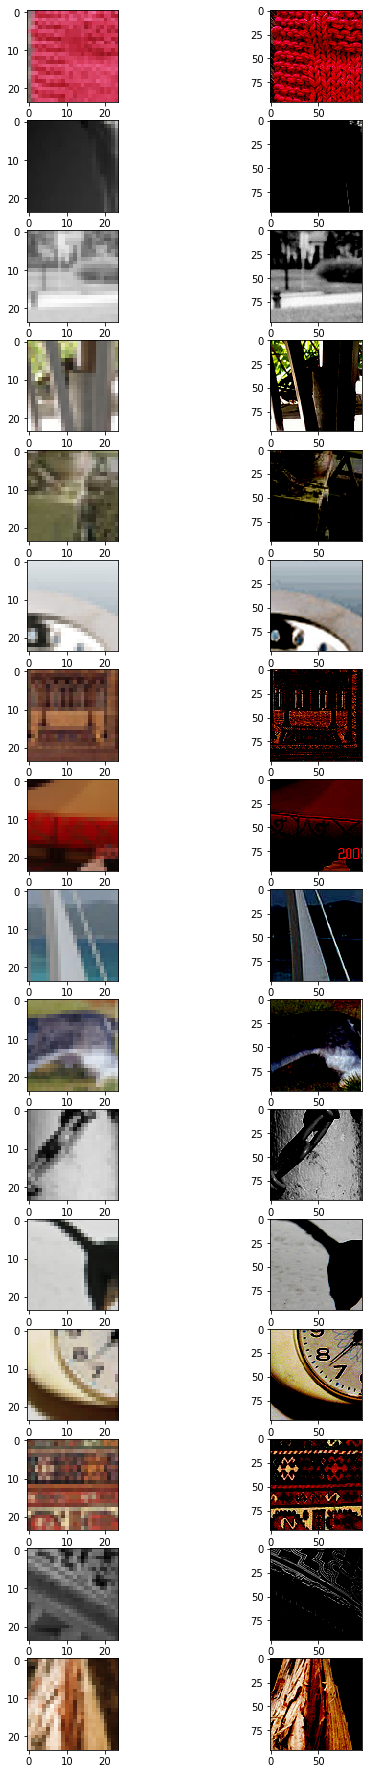

In [12]:
sample_batch = pipeline.show_results()

batch_idx = 0
fig,axes = plt.subplots(nrows=batch_size, ncols=2)
fig.set_figheight(32)
fig.set_figwidth(8)
for idx in range(batch_size):
    img = sample_batch[batch_idx]['lowres'][idx]
    img_hr = sample_batch[batch_idx]['highres'][idx]
    axes[idx, 0].imshow(img)
    axes[idx, 1].imshow(img_hr)
plt.show()

### Training details:

SRRESNET shall be  trained for 1000000 iterations.<br>
The learning rate is to be 1e-4 for all the iterations.


![generator](./Figure/generator.png)

In [13]:
def get_G(input_shape):

    nin = Input(input_shape)
    n = Conv2D(64, 9, 1, padding='SAME', kernel_initializer='he_normal')(nin)
    n = PReLU(shared_axes=[1,2])(n)
    temp = n

    # B residual blocks
    for i in range(16):
        nn = Conv2D(64, 3, 1, padding='SAME', use_bias=False, kernel_initializer='he_normal')(n)
        
        nn = BatchNormalization()(nn)
        nn = PReLU(shared_axes=[1,2])(nn)

        nn = Conv2D(64, 3, 1, padding='SAME', use_bias=False, kernel_initializer='he_normal')(nn)
        nn = BatchNormalization()(nn)
        nn = Add()([n, nn])
        n = nn

    n = Conv2D(64, 3, 1, padding='SAME', use_bias=False, kernel_initializer='he_normal')(n)
    n = BatchNormalization()(n)
    n = Add()([n, temp])
    # B residual blacks end

    n = Conv2D(256, 3, 1, padding='SAME', kernel_initializer='he_normal')(n)
    n = SubPixelConv2D(upsample_factor=2, nchannels=64)(n)
    n = PReLU(shared_axes=[1,2])(n)

    n = Conv2D(256, 3, 1, padding='SAME', kernel_initializer='he_normal')(n)
    n = SubPixelConv2D(upsample_factor=2, nchannels=64)(n)
    n = PReLU(shared_axes=[1,2])(n)

    nn = Conv2D(3, 9, 1, padding='SAME', kernel_initializer='he_normal')(n)
    G = Model(inputs=nin, outputs=nn, name="generator")
    return G

###  Generator Loss 

The SRRESNET model genrates super resolution images(96x96x3) for each low resolution images(24X24X3). The 
super-resolution images and high-resolution images are passed to the PixelMeanSquaredError class to generate mean squared error loss, averaged by the number of pixels.

Content loss could be mse_loss , vgg22_loss or vgg54_loss.The implementation in the note book has gone for mse_loss. Further the results of SRRESNET model would be used for the initialization of SRGAN's generator network.<br>

If there were no obligation towards using SRRESNET model's weights for the initialization of SRGAN's generator model, one may instead of applying a mse_loss between the pixels of predicted image and high-res image, passed the images through vgg network  and attained the feature maps from block2_conv2 layer, and then invoked mse_loss over the feature maps.

In [14]:
class PixelMeanSquaredError(Loss):
    """Calculate mean squared error loss, averaged by number of pixels"""
    
    def __init__(self, y_true=None, y_pred=None, inputs=None, outputs=None, mode=None, **kwargs):

        inputs = self.validate_loss_inputs(inputs, y_true, y_pred)
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.loss_obj = tf.losses.MeanSquaredError(reduction='none', **kwargs)

    def forward(self, data, state):
        true, pred = data
        batch_size, _,_,_ = true.shape
        true = tf.reshape(true,(batch_size,-1))
        pred = tf.reshape(pred,(batch_size,-1))
        loss = self.loss_obj(true, pred)
        return loss


### Creation of the network 


In [15]:
model = fe.build(model_def=lambda : get_G(input_shape=(24,24,3)),
                 model_name="srresnet_gen",
                 optimizer=tf.optimizers.Adam(learning_rate=0.0001),
                 loss_name="mse_loss")
network = fe.Network(ops=[
    ModelOp(inputs= 'lowres', model=model, outputs='superres'),
    PixelMeanSquaredError(inputs=('superres','highres'), outputs="mse_loss")
])

### Create Estimator
Estimator api accepts network object, pipeline object , epochs, steps_per_epoch and trace object and returns an estimator object which can orchestrate the training loop on the training data along with evaluaton on validation data.

### Traces
ModelSaver to save the best generator.


In [16]:
estimator = fe.Estimator(
    network=network,
    pipeline=pipeline,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    traces=[
        ModelSaver(model_name="srresnet_gen", save_dir=model_write_dir, save_best=True),
    ])


### Training begins

In [ ]:
estimator.fit()

### Inference 

In [20]:
from tensorflow.keras.models import load_model
model.load_weights(os.path.join(model_write_dir,'srresnet_gen_best_mse_loss.h5'))

### Determining PSNR(Peak signal to Noise ratio) and SSIM (Structural Similarity)
Note: One may download these images from 
http://vllab.ucmerced.edu/wlai24/LapSRN/results/SR_training_datasets.zip

In [1]:
imgs_pool = glob('/home/ubuntu/fastestimator_data/BSDS200/*.png')
set5_imgs = np.random.choice(imgs_pool, 5)

In [44]:
from skimage import io

def get_low_super_high_res_imgs(set_imgs):
    set_hr,set_lr, set_sr = [], [], []
    for img in set_imgs:
        img = Image.open(img)
        width, height = img.size
        img_hr = np.array(img)
        set_hr.append(img_hr)
        img_lr_pil = img.resize((width//4, height//4),resample=PIL.Image.BICUBIC )
        img_lr = np.array(img_lr_pil)
        img_lr = img_lr /255
        set_lr.append(img_lr)
        
        img_lr = np.expand_dims(img_lr, axis=0)
        img_sr = model(img_lr)
        img_sr = img_sr.numpy()
        img_sr = np.squeeze(img_sr)
        img_sr = np.clip(255 * 0.5 * (img_sr + 1.0), 0.0, 255.0).astype(np.uint8)
        set_sr.append(img_sr)
    return set_hr, set_lr, set_sr
set_hr,set_lr, set_sr = get_low_super_high_res_imgs(set5_imgs)

In [40]:
from skimage.color import rgb2ycbcr,rgb2yuv
def luminance(image):
    lum = rgb2ycbcr(image)[:,:,0]
    lum = lum[4:lum.shape[0]-4, 4:lum.shape[1]-4]
    return lum

def get_psnr(set5_sr, set5_hr):
    psnr = []
    for idx,(sr, hr) in enumerate(zip(set5_sr, set5_hr)):
        sr = np.array(sr, np.uint8)
        if sr.shape == hr.shape:
            psnr.append( peak_signal_noise_ratio(luminance(hr),luminance(sr), data_range=255))
    psnr = np.array(psnr)
    return np.mean(psnr)

def get_ssim(set_sr, set_hr):
    ssim_list = []
    for idx,(sr, hr) in enumerate(zip(set_sr, set_hr)):
        sr = np.array(sr, np.uint8)
        if sr.shape == hr.shape:
            ssim_list.append(structural_similarity(luminance(sr), luminance(hr), data_range=255, multichannel=True))
    ssim_list = np.array(ssim_list)
    return np.mean(ssim_list)

def get_size(set5_sr, set5_hr):
    psnr = []
    for idx,(sr, hr) in enumerate(zip(set5_sr, set5_hr)):
        print(sr.shape, hr.shape)


get_psnr(set_sr, set_hr), get_ssim(set_sr, set_hr)

(31.935710378977586, 0.8813799413126185)

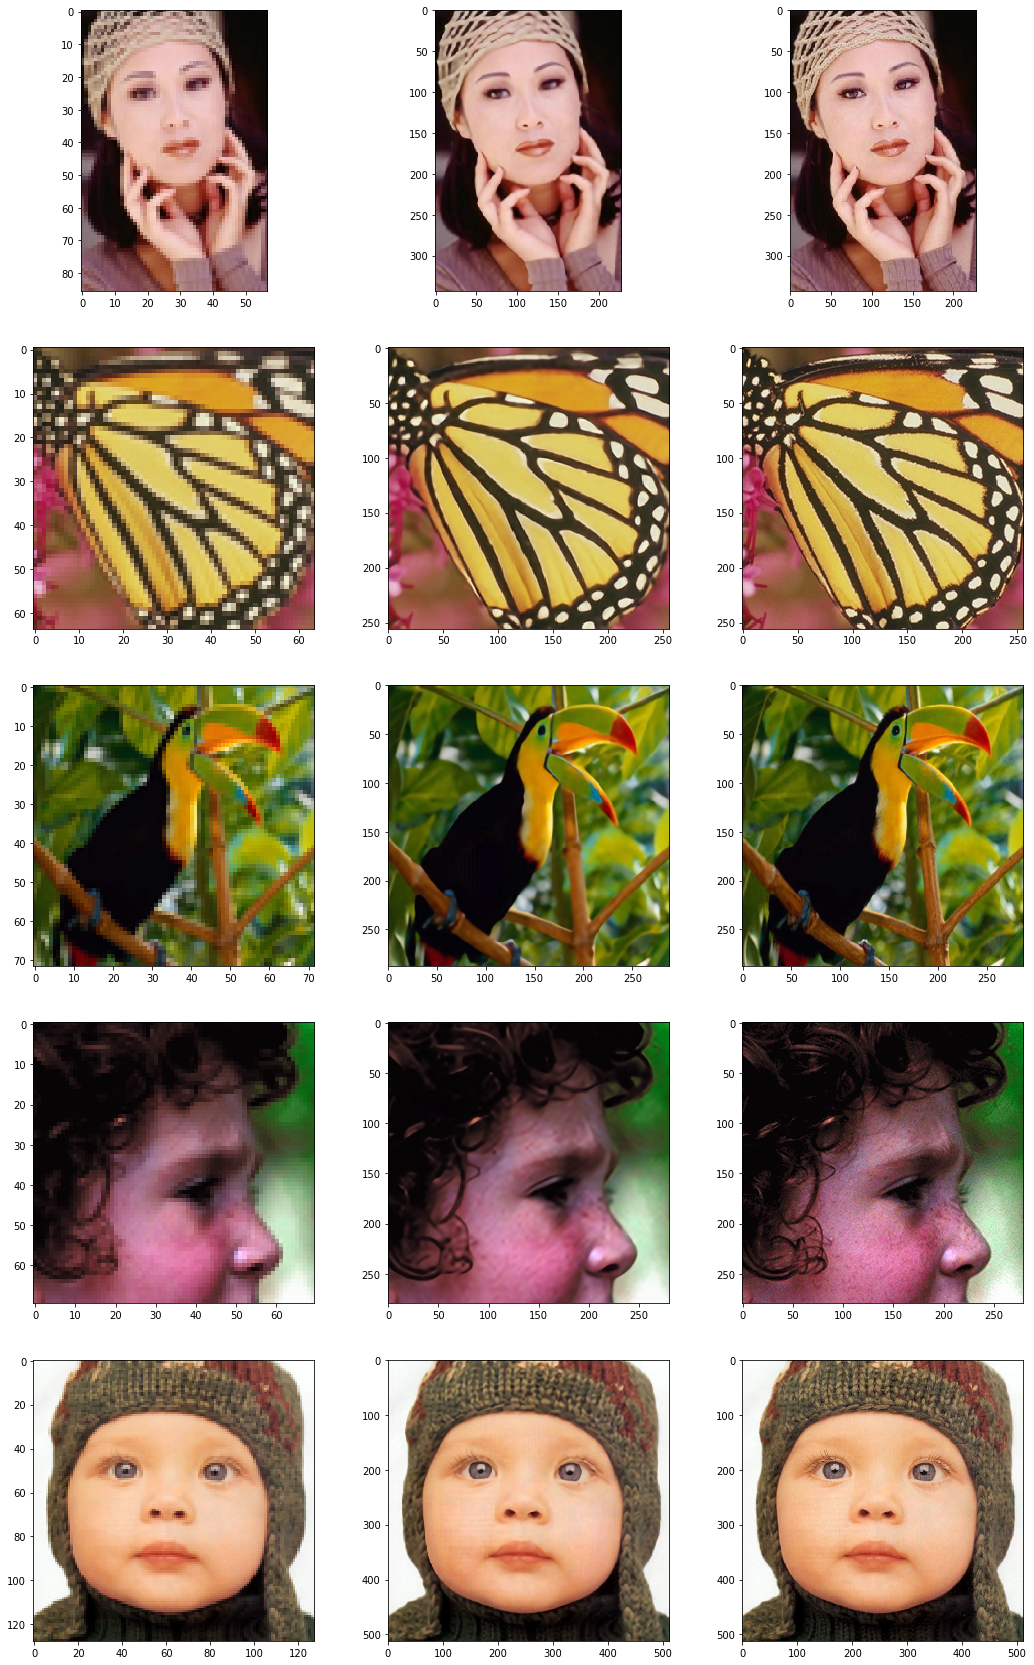

In [41]:
fig , axes = plt.subplots(nrows=5, ncols=3)
fig.set_figheight(30)
fig.set_figwidth(18)
for idx,(lr, sr, hr) in enumerate(zip(set_lr, set_sr, set_hr)):
    axes[idx, 0].imshow(lr)
    axes[idx, 1].imshow(sr)
    axes[idx, 2].imshow(hr)
plt.show()